In [1]:
import torch
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.trainer import TranscriptionalTrainer
from lafomo.utilities.torch import save, load, softplus
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import ToyTimeSeries
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

import numpy as np


In [2]:

    # def predict_f(self, t_predict):
    #     # Sample from the latent distribution
    #     q_f = super().predict_f(t_predict)
    #     f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
    #     print(f.shape)
    #     # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
    #     f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
    #     print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
    #     batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
    #     print(batch_mvn)
    #
    #     return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

In [3]:
from lafomo.datasets import TranscriptomicTimeSeries


class ToyTimeSeries(TranscriptomicTimeSeries):
    class ToyLFM(OrdinaryLFM):
        def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
            super().__init__(num_outputs, gp_model, config)
            num_latents = gp_model.variational_strategy.num_tasks
            self.decay_rate = Parameter(0.2 + 0.6 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
            self.basal_rate = Parameter(0.1 + 0.3 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
            self.sensitivity = Parameter(2 + 5 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
            weight = 0.5 + 1 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32)
            weight[torch.randperm(self.num_outputs)[:15], torch.randint(num_latents, [15])] = 0
            self.weight = Parameter(weight)
            self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

        def initial_state(self):
            return self.basal_rate / self.decay_rate

        def odefunc(self, t, h):
            """h is of shape (num_samples, num_outputs, 1)"""
            self.nfe += 1
            # if (self.nfe % 100) == 0:
            #     print(t)

            decay = self.decay_rate * h

            f = self.f[:, :, self.t_index].unsqueeze(2)
            # print(f.shape, self.sensitivity.shape)
            h = self.basal_rate + f - decay
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t
            return h

        def G(self, f):
            f = softplus(f)
            interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
            f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
            return f

    def __init__(self, num_replicates=1,
                      num_outputs=30,
                      num_latents=3,
                      num_times=10):
        super().__init__()
        self.num_outputs = num_outputs
        config = VariationalConfiguration(
            num_samples=70,
            kernel_scale=False,
            initial_conditions=False # TODO
        )
        with torch.no_grad():
            prediction_points = num_times * 10
            num_inducing = 10  # (I x m x 1)
            inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
            t_predict = torch.linspace(0, 11, prediction_points, dtype=torch.float32)

            gp_model = MultiOutputGP(inducing_points, num_latents, initial_lengthscale=2)
            q_f = gp_model(t_predict)

            samples = q_f.sample(torch.Size([1]))
            plt.figure(figsize=(4, 3))
            for i in range(samples.shape[0]):
                plt.plot(samples[i][:,0], color='blue')
                plt.plot(samples[i][:,1], color='red')
                plt.plot(samples[i][:,2], color='yellow')

            lfm = self.ToyLFM(num_outputs, gp_model, config)
            # print(lfm.weight)
            # with torch.no_grad():
            #     lfm.weight.clamp_(-10, 0)
            # print(lfm.weight)
            # print(lfm.weight_bias)
            plotter = Plotter(lfm, np.arange(num_outputs))
            q_m = plotter.plot_outputs(t_predict)
            self.t_observed = t_predict[::10]
            self.m_observed = q_m.mean[::10].unsqueeze(0).permute(0, 2, 1)
            self.f_observed = q_f.mean[::10].unsqueeze(0).permute(0, 2, 1)
            print(self.m_observed.shape, self.f_observed.shape)
            self.data = [(self.t_observed, self.m_observed[0, i]) for i in range(num_outputs)]

torch.Size([1, 50, 1])


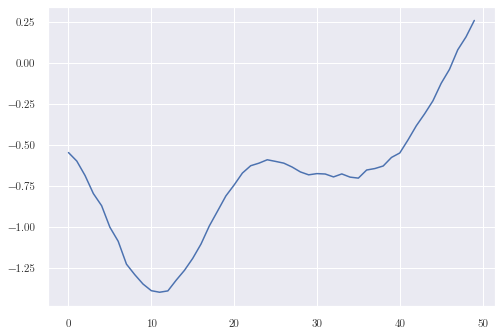

In [15]:
config = VariationalConfiguration(
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False # TODO
)
with torch.no_grad():
    prediction_points = 5 * 10
    num_inducing = 10  # (I x m x 1)
    inducing_points = torch.linspace(0, 12, num_inducing).repeat(1, 1).view(1, num_inducing, 1)
    t_predict = torch.linspace(0, 11, prediction_points, dtype=torch.float32)

    gp_model = MultiOutputGP(inducing_points, 1, initial_lengthscale=2)
    q_f = gp_model(t_predict)

    samples = q_f.sample(torch.Size([1]))
print(samples.shape)
plt.plot(samples[0,:,0].detach())

torch.Size([1, 30, 10]) torch.Size([1, 3, 10])
torch.Size([10])


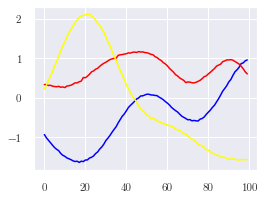

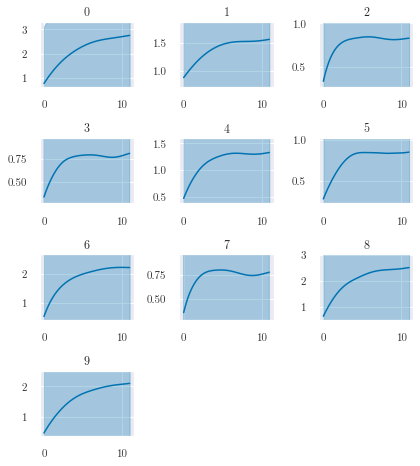

In [10]:
num_latents = 3
num_outputs = 30
dataset = ToyTimeSeries(num_outputs=num_outputs, num_latents=num_latents)
print(dataset.t_observed.shape)

Now let's try to train a model to get the same results

In [5]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        num_latents = gp_model.variational_strategy.num_tasks
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.basal_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        # self.sensitivity = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.weight = Parameter(0.5 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32))
        self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)
        # print(f.shape, self.sensitivity.shape)
        h = self.basal_rate + f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # return f.repeat(1, 10, 1)
        f = softplus(f)
        interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
        f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return f

In [6]:
config = VariationalConfiguration(
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False # TODO
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)

gp_model = MultiOutputGP(inducing_points, num_latents, initial_lengthscale=1)
lfm = TranscriptionLFM(num_outputs, gp_model, config)
plotter = Plotter(lfm, np.arange(num_outputs))

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.02)

trainer = TranscriptionalTrainer(lfm, optimizer, dataset)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\torch\optim\adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [7]:
trainer.train(100, report_interval=5, step_size=1e-1)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\distributions\multivariate_normal.py:230: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,
C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1356: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: For batch 0: U(8,8) is zero, singular U.. Using RootDecomposition.
  NumericalWarning,


Epoch 001/100 - Loss: 56.24 (56.24 0.00) λ: [1.0254701  0.97490185 0.97490185]
Epoch 006/100 - Loss: 41.16 (41.12 0.04) λ: [1.0017245  0.8586735  0.94824445]
Epoch 011/100 - Loss: 35.98 (35.90 0.09) λ: [1.026663   0.84858346 1.0527972 ]
Epoch 016/100 - Loss: 33.00 (32.88 0.12) λ: [1.0177917 0.9701006 1.1714691]
Epoch 021/100 - Loss: 31.21 (31.05 0.16) λ: [0.9326957 1.1101035 1.2544694]
Epoch 026/100 - Loss: 29.85 (29.70 0.15) λ: [0.84224606 1.1576656  1.3077782 ]
Epoch 031/100 - Loss: 28.58 (28.46 0.13) λ: [0.79302484 1.1086061  1.3567177 ]
Epoch 036/100 - Loss: 27.22 (27.11 0.11) λ: [0.71958816 1.0867951  1.3841177 ]
Epoch 041/100 - Loss: 25.91 (25.81 0.10) λ: [0.59679925 1.1193368  1.3789873 ]
Epoch 046/100 - Loss: 24.57 (24.48 0.10) λ: [0.48151174 1.174631   1.3561944 ]
Epoch 051/100 - Loss: 23.21 (23.11 0.09) λ: [0.3995639 1.2120163 1.3304906]
Epoch 056/100 - Loss: 21.81 (21.72 0.09) λ: [0.34082788 1.2238071  1.3090407 ]
Epoch 061/100 - Loss: 20.41 (20.33 0.08) λ: [0.28985792 1.254

NanError: cholesky_cpu: 144 of 432 elements of the torch.Size([3, 12, 12]) tensor are NaN.

In [ ]:
plotter.plot_outputs(t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
plotter.plot_latents(t_predict)

In [10]:
gp_model.covar_module.lengthscale

tensor([[[   nan]],

        [[1.6497]],

        [[1.1077]]], grad_fn=<SoftplusBackward>)